# Set up 

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

# Get the absolute path of the parent directory of the current file (which is 'test')
# current_dir = os.getcwd()
# model_path = os.path.join(current_dir, '..', 'model')
# sys.path.append(model_path)
sys.path.append('..')

from model.Force import HullForce, ControlForce, TowingForce
from model.RigidBody import RigidBody
from model.Simulation import Simulation, Simulation_Result
from model.PlotManager import PlotManager

In [2]:
#Set parameters
m = 0.877 # kg
Vol = 733159.45810955 * 10 ** (-9) #m3
Iyy = 6610.17475482 * 10 ** (-6) #kgm2
hull_surface_area = .0383 #m2
hull_frontal_area = 0.0088
hull_cd = 1.2
hull_corr_factor = 0.75
hull_chord = .215

r_xi = -111.76 * 10 ** (-3) #m 
r_zi = 0.722 * 10 ** (-3) #m

r_xh = 0
r_zh = 0

r_xb = 0
r_zb = 0

r_xt = 42.9 * 10**(-3)
r_zt = -75 * 10**(-3)

# Aero foil parameters
ctrl_AR = 2.61 #aspect ratio
ctrl_area = 0.025 #planform area
ctrl_stall_threshold = 10 #Angle of attack stall threshold
ctrl_Cl_a = 0.1/np.deg2rad(1)
ctrl_Cl_alpha_offset = 0.5
ctrl_chord = 0.1

#Towing parameters
tow_magnitude = 10 #N gets overritten by equilibrium optimization
drone_height = 3 #m above water
drone_tow_length = 5 #m 
probe_depth = 0.3

## Initialize the models

In [3]:
rigidbody = RigidBody(m, Vol, Iyy, np.array([r_xb, r_zb]))
towForce = TowingForce(np.array([r_xt,r_zt]), tow_magnitude, drone_height, drone_tow_length, probe_depth)
controlForce = ControlForce(np.array([r_xi,r_zi]),np.deg2rad(-5), ctrl_AR, ctrl_area, ctrl_chord, ctrl_stall_threshold, ctrl_Cl_a, ctrl_Cl_alpha_offset)
hullForce = HullForce(np.array([r_xh,r_zh]), hull_surface_area, hull_frontal_area, hull_chord, hull_cd, hull_corr_factor)

sim = Simulation(rigidbody,towForce,hullForce,[controlForce])

plot = PlotManager()

# Solve Equilibrium Point

Optimization Results:
----------------------
Parameter       Value           Units     
----------------------
Pitch Angle     -2.59           degrees   
Delta_t         27.48           degrees   
Towing Force    19.01           N         
Delta_i         6.46            degrees   
----------------------
Inertial Vel X: 0.00           m/s       
Inertial Vel Z: -0.00          m/s       
Pitch Rate:     -0.00          rad/s     
Inertial Acc X: 0.00           m/s       
Inertial Acc Z: -0.00          m/s       
Pitch Acc:      -0.00          rad/s     
Residual Norm: 0.000000
Optimization successful!




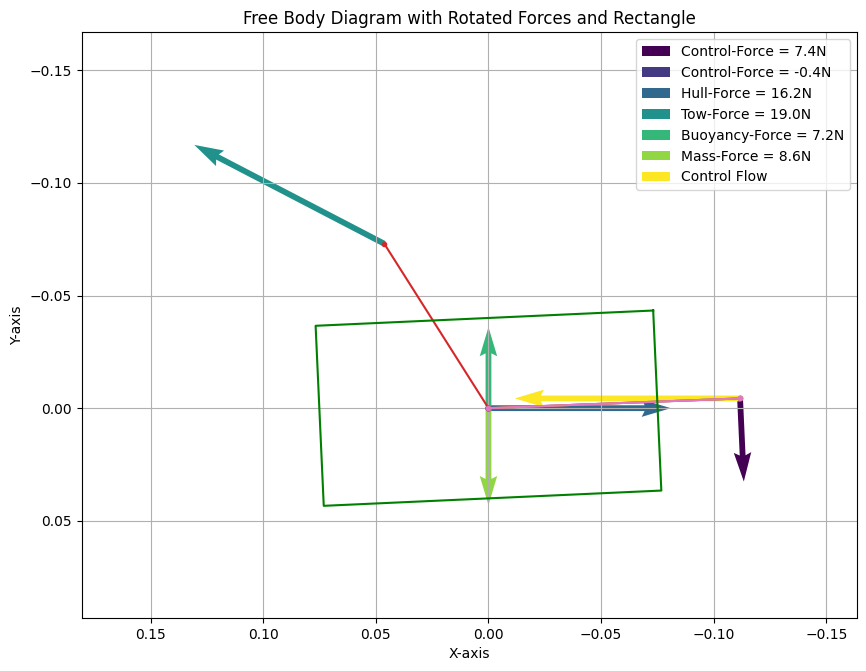

In [4]:
#Find equilibrium by minimizing Forces and moment individually using least squares
Velocity = 2 #m/s in inertial frame
results_LS = sim.solve_equilibrium_state_LS_Vel(Velocity,1)
print("")
print("")

#print("Old Method:")
#results_LS = sim.solve_equilibrium_state_LS(Velocity,1)


#initial_state = np.zeros(9)
#initial_state[2] = results_LS[0]
#initial_state[3] = 2

_, _ = plot.plotfbd(sim, sim.eq_sim)

# Equilibrium Simulation

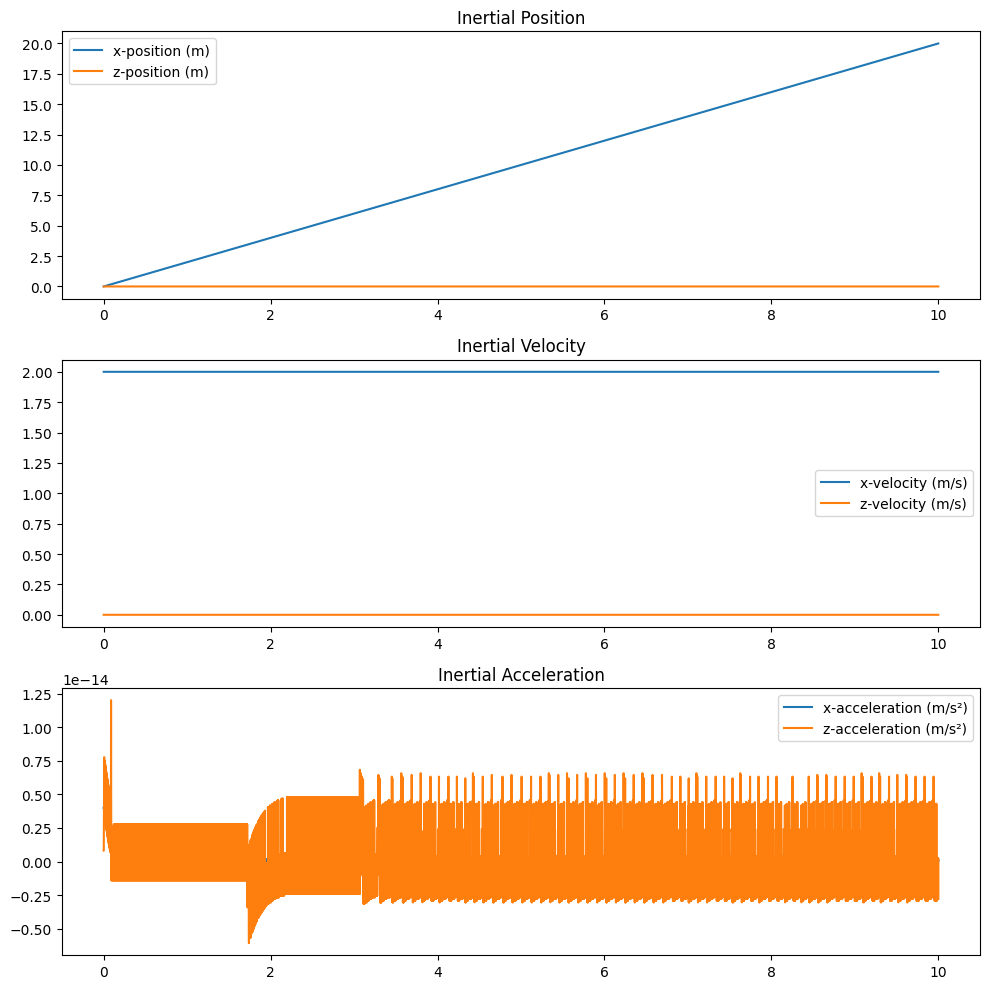

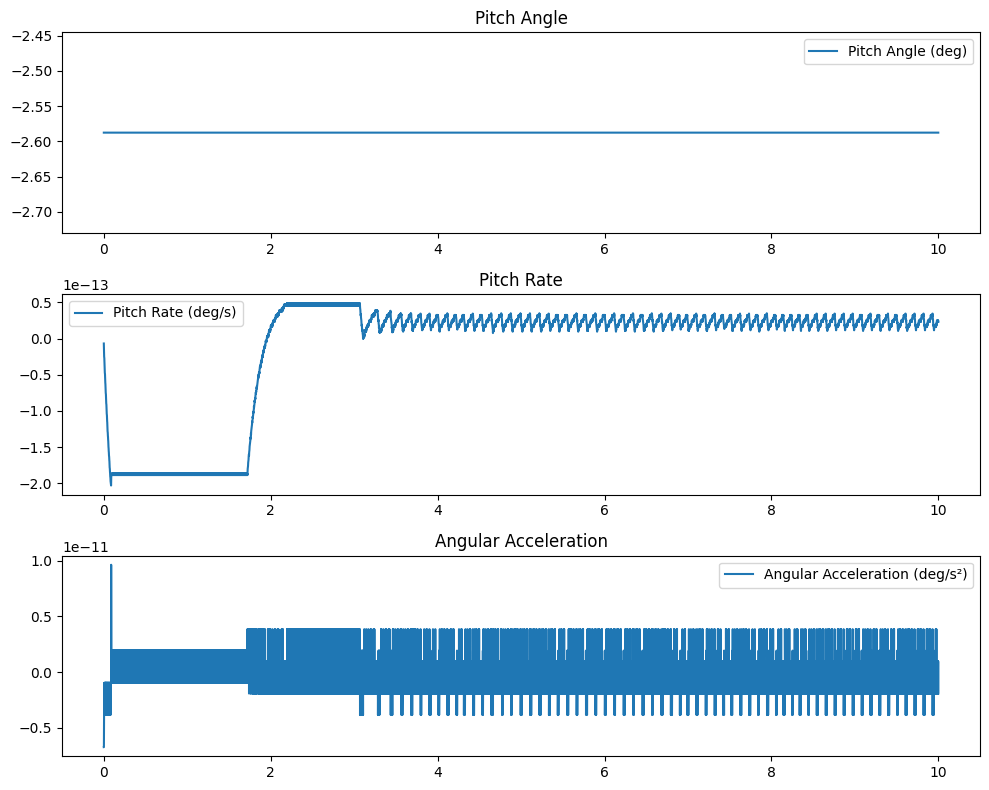

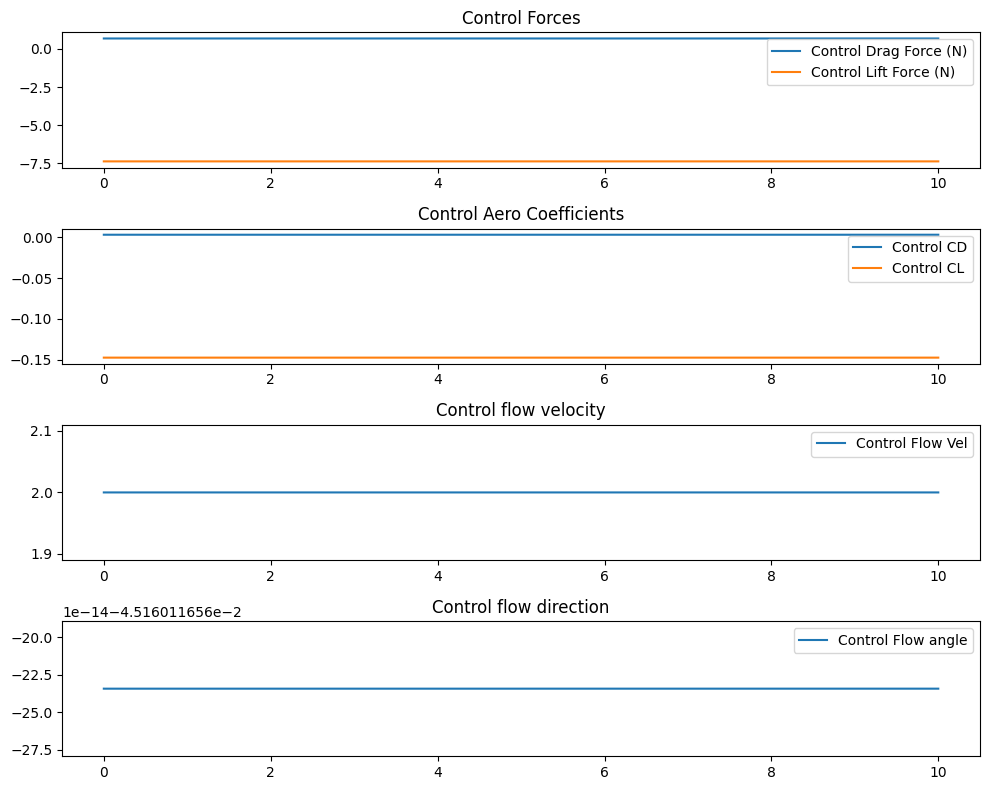

In [5]:
#print(initial_state)
euler_sim_results = sim.simulate_forward_euler(10000, 0.001, Velocity)
#plot.gen_gif(sim, euler_sim_results)
plot.plot_simulation_results(euler_sim_results)

In [6]:
# plot.plot_all_results(euler_sim_results)

# Perturbation Simulation

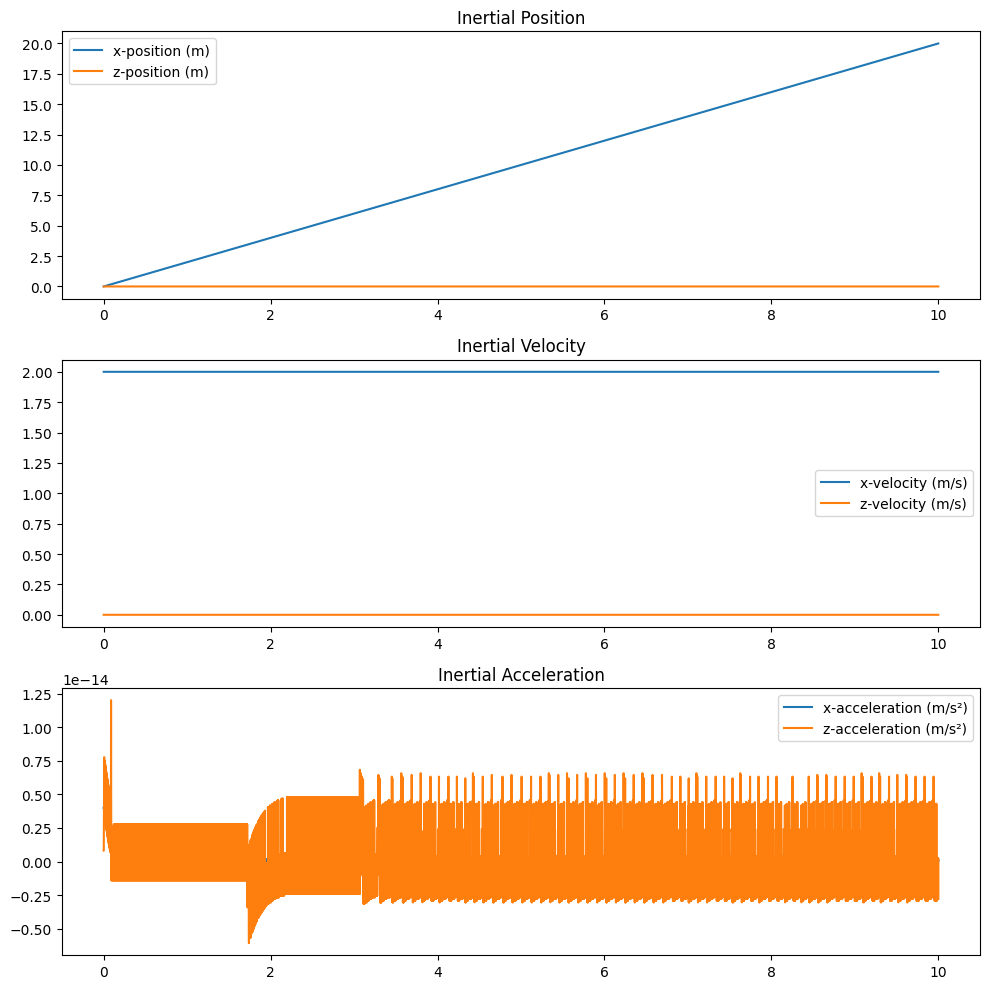

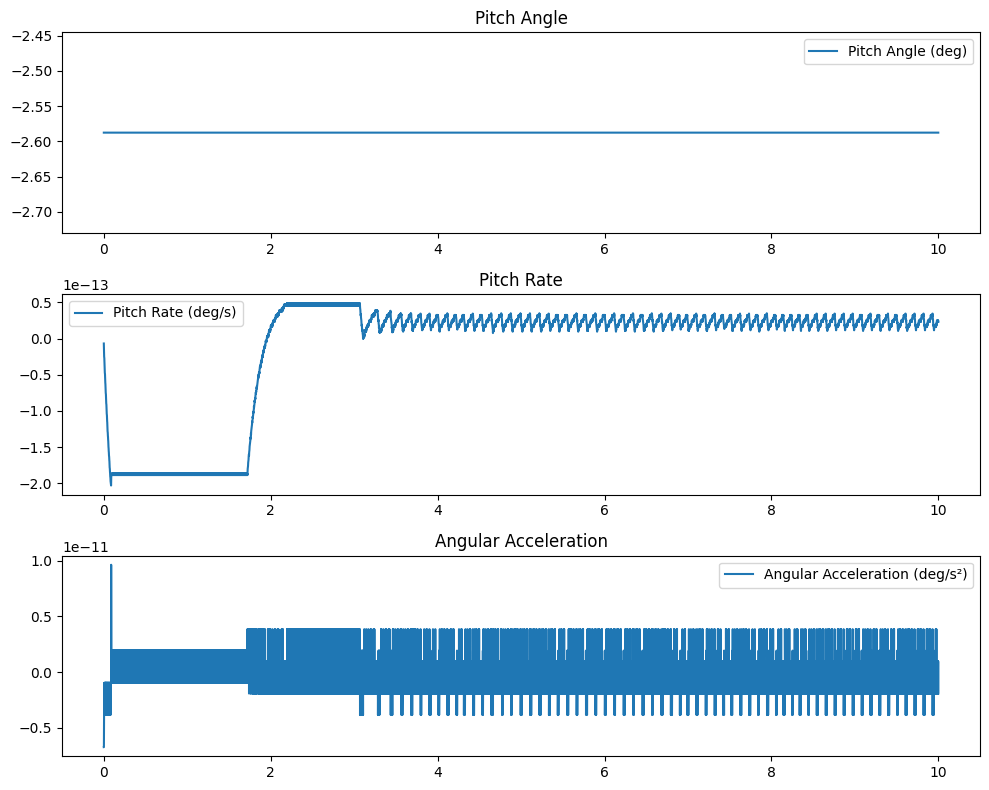

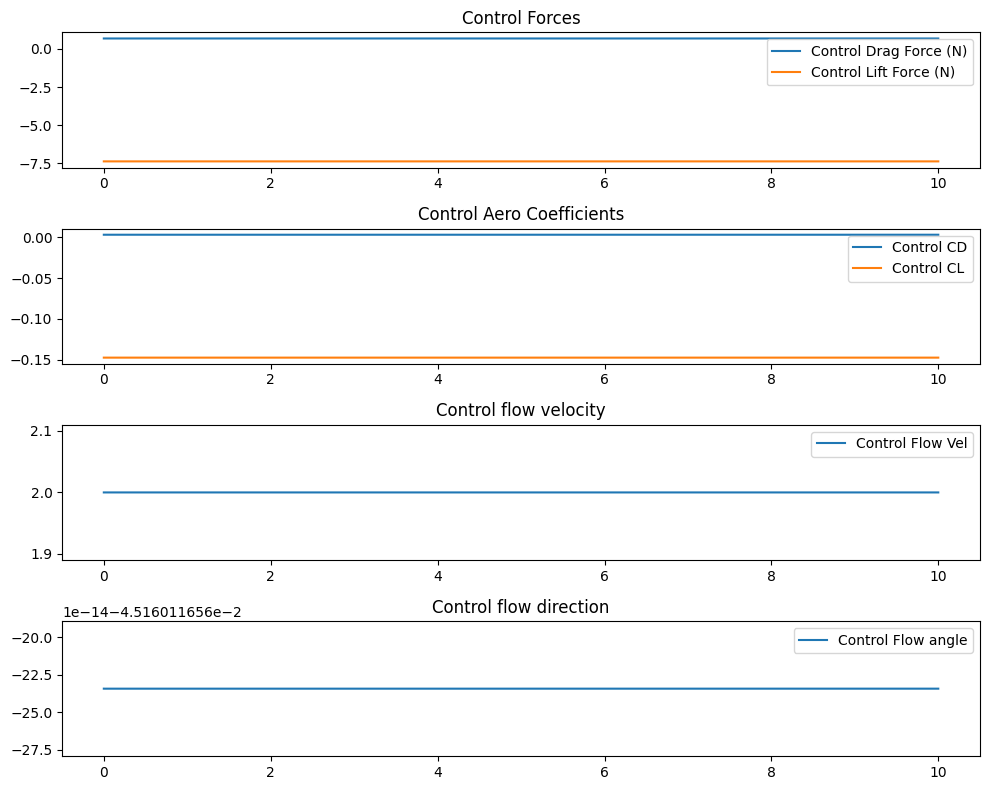

In [ ]:
perturbed_state = [0, 0, 0, 0, 0 ,0.1] #Change Velocity

pertub_euler_sim_results = sim.simulate_forward_euler(1000, 0.001, Velocity, perturbed_state)
plot.plot_simulation_results(euler_sim_results)
#plot.plot_all_results(pertub_euler_sim_results)

# Jacobian & Eigenvalues

[  0.         +0.j         392.90484881 +0.j
   0.40587235 +0.j           8.39517127+10.91915408j
   8.39517127-10.91915408j  19.11899474 +0.j        ]


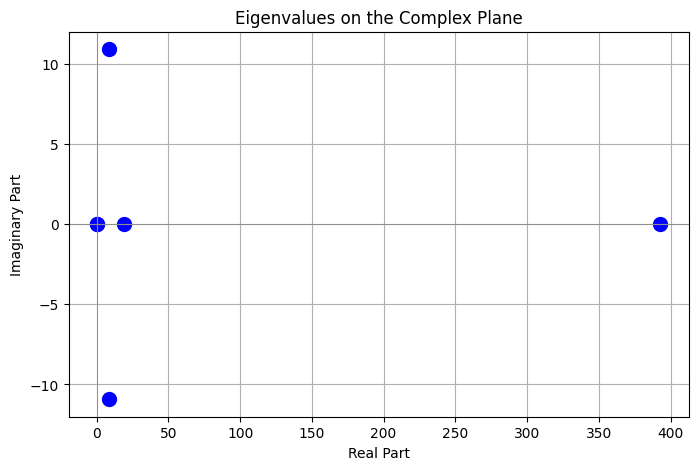

In [8]:
jacobian = sim.calculate_jacobian(Velocity, 1e-5)
eigs= np.linalg.eig(jacobian)
#print(jacobian)

# Sample list of complex eigenvalues
eigenvalues = eigs[0]
print(eigenvalues)

# Extract real and imaginary parts
real_parts = [z.real for z in eigenvalues]
imag_parts = [z.imag for z in eigenvalues]

# Plotting
plt.figure(figsize=(8,5))
plt.axhline(0, color='grey', lw=0.5)  # x-axis
plt.axvline(0, color='grey', lw=0.5)  # y-axis
plt.scatter(real_parts, imag_parts, color='blue', marker='o', s=100)

# Labels and title
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Eigenvalues on the Complex Plane")
plt.grid(True)
plt.show()

In [9]:
# Iyy = 6610.17475482 * 10 ** (-6) #kgm2
# Var = np.linspace(Iyy, Iyy*2,5)

# for j in [0,1,2,3,4]:
#     sim.rigidbody.Iyy = Var[j]
#     v = [1,2,3,4,5]
#     eigenvalues = []
#     cmap = plt.cm.viridis
#     colors = cmap(np.linspace(0,1,len(v)))
#     plt.figure(figsize=(8,5))
#     for i in [0,1,2,3,4]:
#         results_LS = sim.solve_equilibrium_state_LS(2)
#         pitch_angle = results_LS[0]
#         velocity = v[i]
#         jacobian = sim.calculate_jacobian(velocity, pitch_angle, 1e-3)
#         eigs= np.linalg.eig(jacobian)
#         #print(jacobian)

#         # Sample list of complex eigenvalues
#         eigenvalues = eigs[0]

#         # Extract real and imaginary parts
#         real_parts = [z.real for z in eigenvalues]
#         imag_parts = [z.imag for z in eigenvalues]

#         # Plotting
#         #
        
#         plt.scatter(real_parts, imag_parts, color=colors[i] , marker='o', s=100, label=str(v[i])+" m/s")

#     # Labels and title
#     plt.xlabel("Real Part")
#     plt.ylabel("Imaginary Part")
#     plt.title("Eigenvalues on the Complex Plane " + str(Var[j]))
#     plt.axhline(0, color='grey', lw=0.5)  # x-axis
#     plt.axvline(0, color='grey', lw=0.5)  # y-axis
#     plt.legend()
#     plt.grid(True)
#     plt.show()
